# Electricity consumption - Models training, evaluation and prediction

## Sections
1. Read and prepare datasets
2. Linear regression model definition
    - Compute correlations between independant variables
    - Define linear regression models and formula
3. Linear regression model training and prediction with cross-validation
    - Define the cross-validation plan
    - Train model with cross-validaiton plan
    - Predict consumption values
4. Linear regression model performance evaluation
    - Evaluate the model with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)
    - Visualization of cross-validation prediction values and prediction values based on all data frame
5. Random forest model definition
    - Define random forest models and formula (same as linear regression)
6. Random forest model training and prediction with cross-validation
    - Define the cross-validation plan
    - Train model with cross-validaiton plan
    - Predict consumption values
7. Random forest model performance evaluation
    - Evaluate the model with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)
    - Visualization of cross-validation prediction values and prediction values based on all data frame

### 1. Read and prepare datasets

##### Import libraries

In [26]:
# Import libraries for plotting, reading and wrangling data
library(tidyverse)
library(scales)
library(here)
library(ggplot2)
library(vtreat)
library(cowplot)
library(ranger)
source(here::here("scripts/Common", "func.R"))

##### Read datasets

In [27]:
# Read electricity datasets: Hourly, Daily, Monthly
ElecHourDF  <-  read_csv(here::here("curated/electricity", "gold_hourly_electricity.csv"),   show_col_types = FALSE)
ElecDayDF   <-  read_csv(here::here("curated/electricity", "gold_daily_electricity.csv"),    show_col_types = FALSE)
ElecMonthDF <-  read_csv(here::here("curated/electricity", "gold_monthly_electricity.csv"),  show_col_types = FALSE) %>%
                mutate(year_month = factor(paste(year, month, sep = "-")))

# Read weather datasets: Hourly, Daily, Monthly
WeatherHourDF  <-   read_csv(here::here("curated/weather", "gold_hourly_weather.csv"),   show_col_types = FALSE)
WeatherDayDF   <-   read_csv(here::here("curated/weather", "gold_daily_weather.csv"),    show_col_types = FALSE)
WeatherMonthDF <-   read_csv(here::here("curated/weather", "gold_monthly_weather.csv"),  show_col_types = FALSE) %>%
                    mutate(year_month = factor(paste(year, month, sep = "-")))

##### Prepare dataframes

In [28]:
# Join hourly weather and electricity data
WEHourDF <- WeatherHourDF %>%
    inner_join(ElecHourDF,   by = c("year", "month", "day", "hour"), suffix = c("", "_elec")) %>%
    select(year, month, day, hour, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# Join daily weather and electricity data
WEDayDF <- WeatherDayDF %>%
    inner_join(ElecDayDF,   by = c("year", "month", "day"), suffix = c("", "_elec")) %>%
    select(year, month, day, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)
# Join monthly weather and electricity data
WEMonthDF <- WeatherMonthDF %>%
    inner_join(ElecMonthDF,   by = c("year_month", "year", "month"), suffix = c("", "_elec")) %>%
    select(year_month, year, month, avg_temp, avg_dewpt_temp, avg_rel_hum_pct, avg_wind_dir, avg_wind_spd, avg_visib, avg_stn_press, avg_hmdx, avg_wind_chill, consumption)

### 2. Linear regression model definition

##### Compute correlations between independant variables
This will give inputs about interactions that need to be defined in the linear regression model formula

In [29]:
# Define the vector for weather metrics
corrVec <- c("avg_temp", "avg_dewpt_temp", "avg_rel_hum_pct", "avg_visib")
# Create correlation dataframe for hourly data
corrHourDF  <- pairwise_correlations_function(WEHourDF, corrVec, "hour")
# Create correlation dataframe for daily data
corrDayDF   <- pairwise_correlations_function(WEDayDF, corrVec, "day")
# Create correlation dataframe for monthly data
corrMonthDF <- pairwise_correlations_function(WEMonthDF, corrVec, "month")
# Combine all three dataframe together
combinedCorrsDF <- corrHourDF %>%
    union(corrDayDF) %>%
        union(corrMonthDF)

# Display correlation results
head(
    combinedCorrsDF %>%
        pivot_wider(names_from = timeFrame, values_from = correlation)
)

independantVariableOne,independantVariableTwo,hour,day,month
<chr>,<chr>,<dbl>,<dbl>,<dbl>
avg_temp,avg_dewpt_temp,0.888,0.922,0.961
avg_temp,avg_rel_hum_pct,-0.394,-0.324,-0.578
avg_temp,avg_visib,0.391,0.420,0.833
avg_dewpt_temp,avg_rel_hum_pct,0.067,0.067,-0.332
avg_dewpt_temp,avg_visib,0.142,0.174,0.712
avg_rel_hum_pct,avg_visib,-0.587,-0.665,-0.748


##### Define formula and linear regression models

In [30]:
#=========================
# FORMULA
#=========================
# Define model formula
# Only the independant variables that have a correlation higher than 50% for all time frames are considered for interactions
fmla_linear_regression <- as.formula("consumption ~ avg_temp + avg_dewpt_temp + avg_rel_hum_pct + avg_visib + avg_temp:avg_dewpt_temp + avg_rel_hum_pct:avg_visib")

#===========================================
# LINEAR REGRESSION MODELS BASED ON ALL DATA
#===========================================
# Create linear regression models for all three time frames
mdl_linear_regression_hour  <- lm(fmla_linear_regression, data = WEHourDF)
mdl_linear_regression_day   <- lm(fmla_linear_regression, data = WEDayDF)
mdl_linear_regression_month <- lm(fmla_linear_regression, data = WEMonthDF)

# Add column with prediction values based on all data (1 training set = all data frame)
WEHourDF$pred   <- predict(mdl_linear_regression_hour,  WEHourDF)
WEDayDF$pred    <- predict(mdl_linear_regression_day,   WEDayDF)
WEMonthDF$pred  <- predict(mdl_linear_regression_month, WEMonthDF)

### 3. Linear regression model training and prediction with cross-validation

In [31]:
# HOUR
WEHourDF    <- cross_validation_func(WEHourDF,  3, fmla_linear_regression, "linear_regression")
# DAY
WEDayDF     <- cross_validation_func(WEDayDF,   3, fmla_linear_regression, "linear_regression")
# MONTH
WEMonthDF   <- cross_validation_func(WEMonthDF, 3, fmla_linear_regression, "linear_regression")

### 4. Linear regression model performance evaluation

##### Evaluate the model with cross-validation vs. all data combined (RMSE, R-squared, Standard Deviation)

In [32]:
#=======================================
# MODEL BASED ON ALL DATA
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixAllData <- data.frame(
    timeFrame = c("hour", "day", "month"),
    rSquared = c(
        summary(mdl_linear_regression_hour)$r.squared,      
        summary(mdl_linear_regression_day)$r.squared,       
        summary(mdl_linear_regression_month)$r.squared
    ),
    rmse = c(
        rmse_func(WEHourDF,     "consumption", "pred"),         
        rmse_func(WEDayDF,      "consumption", "pred"),          
        rmse_func(WEMonthDF,    "consumption", "pred")
    ),
    sd = c(
        sd(WEHourDF$consumption),                           
        sd(WEDayDF$consumption),                            
        sd(WEMonthDF$consumption)
    ),
    # If RMSE smaller than SD: Model tends to estimate consumption better than simply taking the average of the data itself
    rmseIsSmallerThanSd  = c(
        rmse_func(WEHourDF,     "consumption", "pred") < sd(WEHourDF$consumption), 
        rmse_func(WEDayDF,      "consumption", "pred") < sd(WEDayDF$consumption), 
        rmse_func(WEMonthDF,    "consumption", "pred") < sd(WEMonthDF$consumption)
    )
)
# Display performance results
head(ModelsPerformanceMatrixAllData)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,0.03187595,0.6649962,0.6758745,TRUE
2,day,0.25941649,4.9697430,5.7788920,TRUE
3,month,0.82543950,46.0462237,112.5803861,TRUE


In [33]:
#=======================================
# MODEL CROSS-VALIDATION
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixCV <- data.frame(
    timeFrame = c("hour", "day", "month"),
    rSquared = c(
        r_squared_func(WEHourDF,    "consumption", "predCV"), 
        r_squared_func(WEDayDF,     "consumption", "predCV"), 
        r_squared_func(WEMonthDF,   "consumption", "predCV")
    ),
    rmse = c(
        rmse_func(WEHourDF,     "consumption", "predCV"), 
        rmse_func(WEDayDF,      "consumption", "predCV"), 
        rmse_func(WEMonthDF,    "consumption", "predCV")
    ),
    sd = c(
        sd(WEHourDF$consumption), 
        sd(WEDayDF$consumption), 
        sd(WEMonthDF$consumption)
    ),
    # If RMSE smaller than SD: Model tends to estimate consumption better than simply taking the average of the data itself
    rmseIsSmallerThanSd  = c(
        rmse_func(WEHourDF,     "consumption", "predCV") < sd(WEHourDF$consumption), 
        rmse_func(WEDayDF,      "consumption", "predCV") < sd(WEDayDF$consumption), 
        rmse_func(WEMonthDF,    "consumption", "predCV") < sd(WEMonthDF$consumption)
    )
)
# Display performance results
head(ModelsPerformanceMatrixCV)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,0.03129277,0.6651965,0.6758745,TRUE
2,day,0.23821092,5.0403916,5.7788920,TRUE
3,month,0.64276971,65.8711388,112.5803861,TRUE


##### Visualization of cross-validation prediction values and prediction values based on all data frame

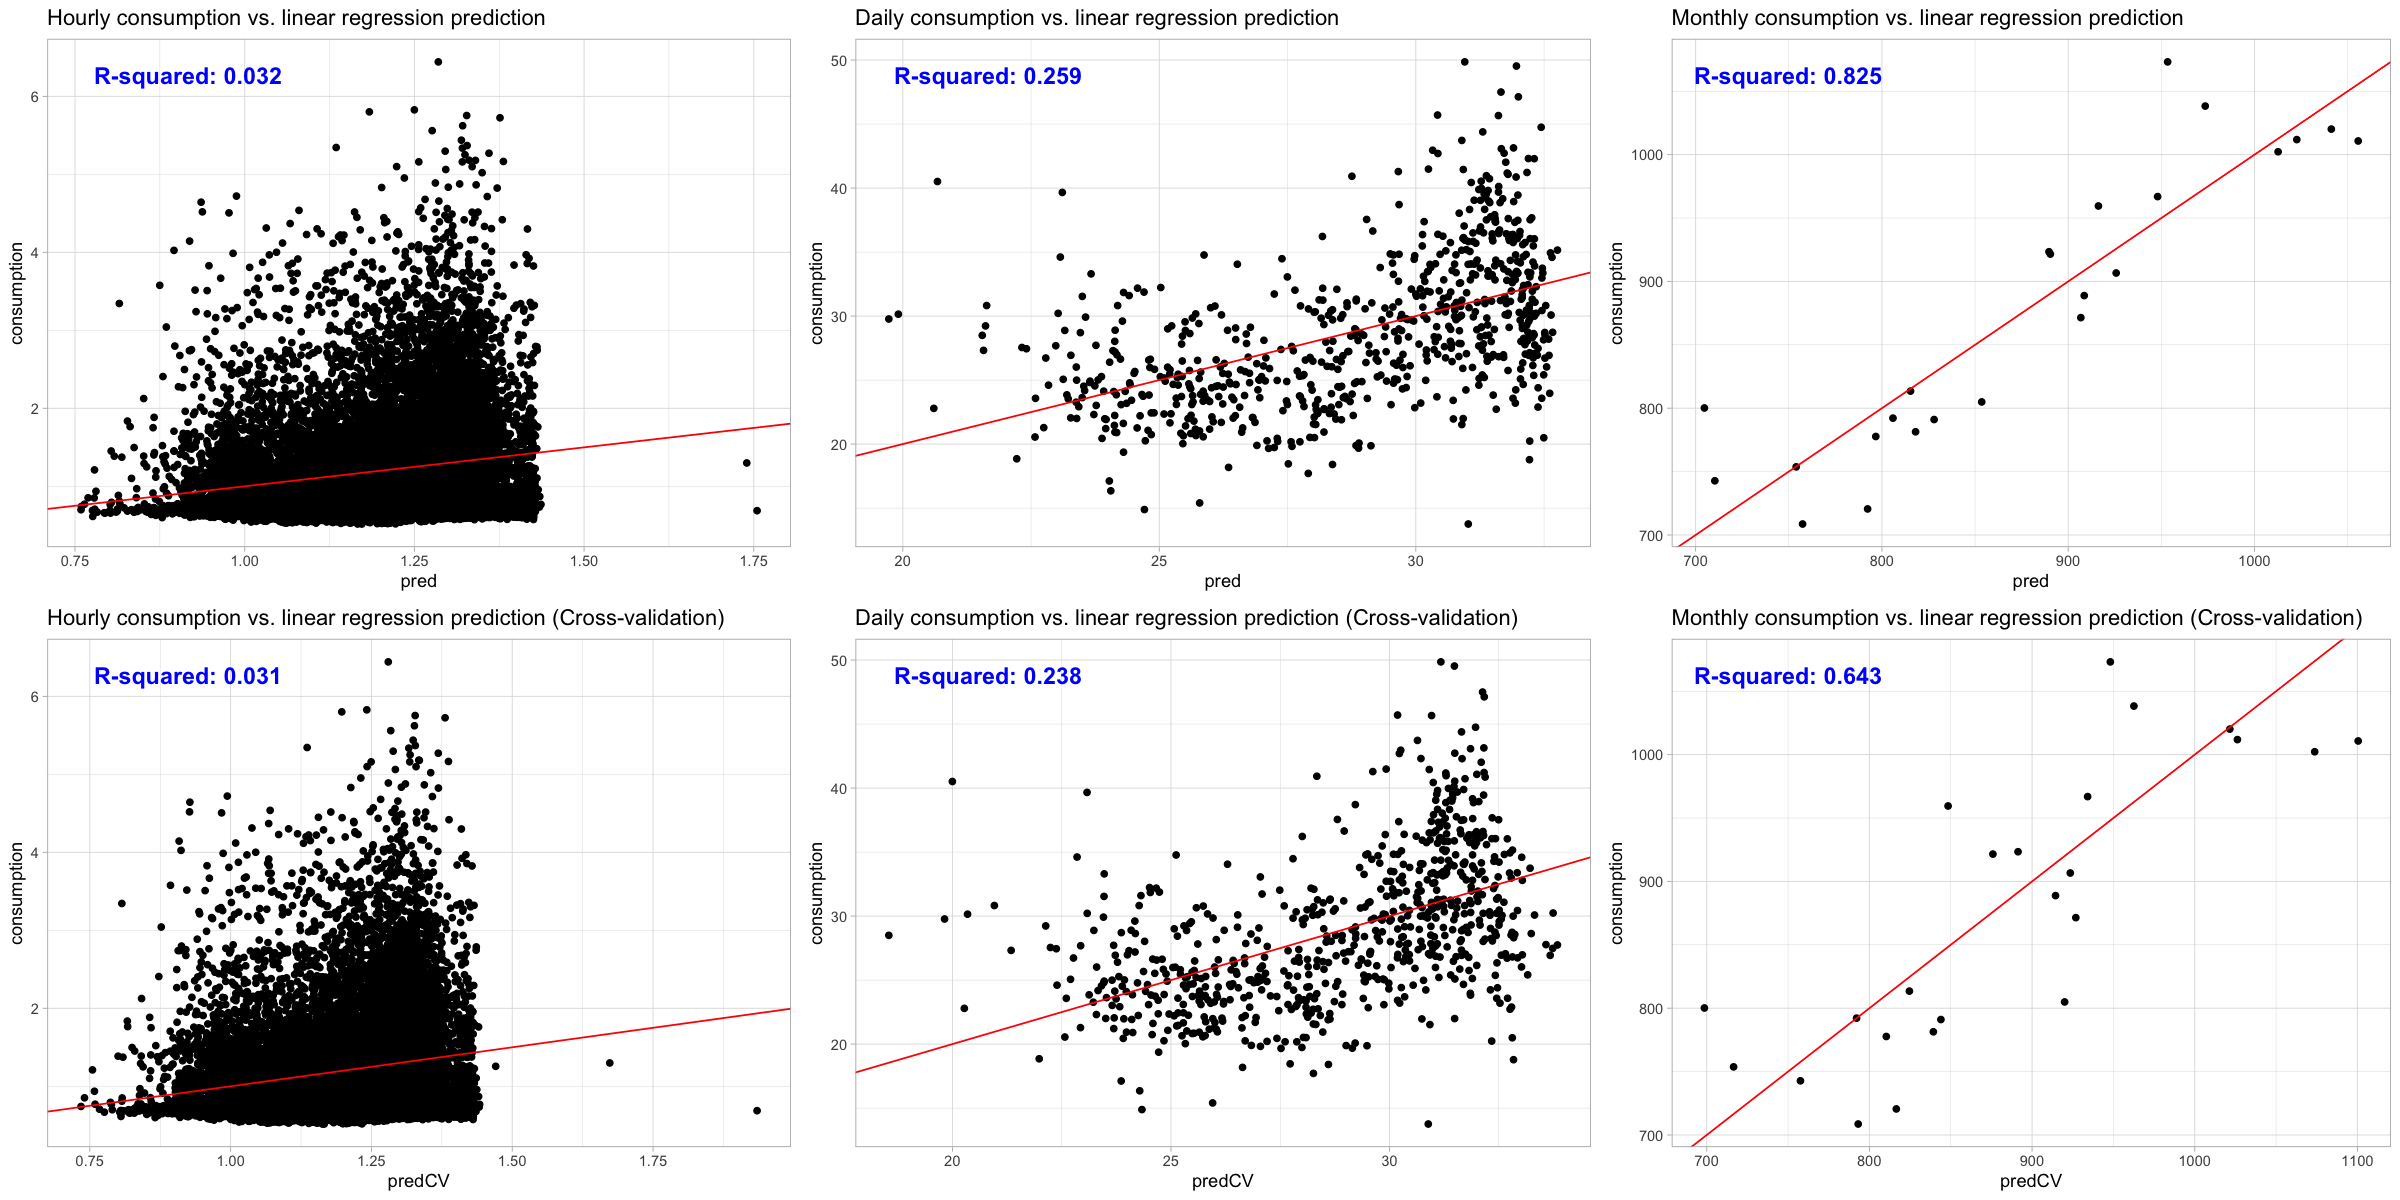

In [34]:
# Set configuration for plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot definitions
plt_hour_pred       <- ggplot(WEHourDF,     aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. linear regression prediction")                      + theme_light()
plt_day_pred        <- ggplot(WEDayDF,      aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. linear regression prediction")                       + theme_light()
plt_month_pred      <- ggplot(WEMonthDF,    aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction")                     + theme_light()
plt_hour_predCV     <- ggplot(WEHourDF,     aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. linear regression prediction (Cross-validation)")   + theme_light()
plt_day_predCV      <- ggplot(WEDayDF,      aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. linear regression prediction (Cross-validation)")    + theme_light()
plt_month_predCV    <- ggplot(WEMonthDF,    aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. linear regression prediction (Cross-validation)")  + theme_light()

# Grid of plots definition
plot_grid(
    plt_hour_pred, plt_day_pred, plt_month_pred, plt_hour_predCV, plt_day_predCV, plt_month_predCV,
    labels = c(
        paste0("R-squared: ", round(r_squared_func(WEHourDF,    "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEDayDF,     "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEMonthDF,   "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEHourDF,    "consumption", "predCV"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEDayDF,     "consumption", "predCV"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEMonthDF,   "consumption", "predCV"), 3))
    ), 
    hjust = -0.5, vjust = 5, label_colour = "blue",
    ncol = 3, nrow = 2
)

### 5. Random forest model definition

##### Define random forest models and formula (same as linear regression)

In [44]:
#=========================
# FORMULA
#=========================
# Define model formula
# Only the independant variables that have a correlation higher than 50% for all time frames are considered for interactions
# The correlation values were calculated in the section 2 of this notebook
# The fmla_random_forest is the same as the one in the linear regression, named: fmla_linear_regression
fmla_random_forest <- as.formula("consumption ~ avg_temp + avg_dewpt_temp + avg_rel_hum_pct + avg_visib")

#===========================================
# RANDOM FOREST MODELS BASED ON ALL DATA
#===========================================
# Create linear regression models for all three time frames
mdl_random_forest_hour  <- ranger(fmla_random_forest, WEHourDF, num.trees = 500, respect.unordered.factors = "order")
mdl_random_forest_day   <- ranger(fmla_random_forest, WEDayDF, num.trees = 500, respect.unordered.factors = "order")
mdl_random_forest_month <- ranger(fmla_random_forest, WEMonthDF, num.trees = 500, respect.unordered.factors = "order")

# Add column with prediction values based on all data (1 training set = all data frame)
WEHourDF$pred   <- predict(mdl_random_forest_hour,  WEHourDF)$predictions
WEDayDF$pred    <- predict(mdl_random_forest_day,   WEDayDF)$predictions
WEMonthDF$pred  <- predict(mdl_random_forest_month, WEMonthDF)$predictions

### 6. Random forest model training and prediction with cross-validation
- Define the cross-validation plan
- Train model with cross-validaiton plan
- Predict consumption values

##### Define cross-validation plan and train data

In [46]:
# HOUR
WEHourDF    <- cross_validation_func(pDF = WEHourDF,  pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest")
# DAY
WEDayDF     <- cross_validation_func(pDF = WEDayDF,   pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest")
# MONTH
WEMonthDF   <- cross_validation_func(pDF = WEMonthDF, pKFolds = 3, pFormula = fmla_random_forest, pModel = "random_forest")

In [51]:
#=======================================
# MODEL BASED ON ALL DATA
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixAllData <- data.frame(
    timeFrame = c("hour", "day", "month"),
    rSquared = c(
        mdl_random_forest_hour$r.squared,
        mdl_random_forest_day$r.squared,
        mdl_random_forest_month$r.squared
    ),
    rmse = c(
        rmse_func(WEHourDF,     "consumption", "pred"),         
        rmse_func(WEDayDF,      "consumption", "pred"),          
        rmse_func(WEMonthDF,    "consumption", "pred")
    ),
    sd = c(
        sd(WEHourDF$consumption),                           
        sd(WEDayDF$consumption),                            
        sd(WEMonthDF$consumption)
    ),
    # If RMSE smaller than SD: Model tends to estimate consumption better than simply taking the average of the data itself
    rmseIsSmallerThanSd  = c(
        rmse_func(WEHourDF,     "consumption", "pred") < sd(WEHourDF$consumption), 
        rmse_func(WEDayDF,      "consumption", "pred") < sd(WEDayDF$consumption), 
        rmse_func(WEMonthDF,    "consumption", "pred") < sd(WEMonthDF$consumption)
    )
)
# Display performance results
head(ModelsPerformanceMatrixAllData)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,-0.07368162,0.4178211,0.6758745,TRUE
2,day,0.37971222,2.0441311,5.7788920,TRUE
3,month,0.68402163,29.0976705,112.5803861,TRUE


In [49]:
#=======================================
# MODEL CROSS-VALIDATION
#=======================================
# Create matrix containing all metrics needed for model performance evaluation
ModelsPerformanceMatrixCV <- data.frame(
    timeFrame = c("hour", "day", "month"),
    rSquared = c(
        r_squared_func(WEHourDF,    "consumption", "predCV"), 
        r_squared_func(WEDayDF,     "consumption", "predCV"), 
        r_squared_func(WEMonthDF,   "consumption", "predCV")
    ),
    rmse = c(
        rmse_func(WEHourDF,     "consumption", "predCV"), 
        rmse_func(WEDayDF,      "consumption", "predCV"), 
        rmse_func(WEMonthDF,    "consumption", "predCV")
    ),
    sd = c(
        sd(WEHourDF$consumption), 
        sd(WEDayDF$consumption), 
        sd(WEMonthDF$consumption)
    ),
    # If RMSE smaller than SD: Model tends to estimate consumption better than simply taking the average of the data itself
    rmseIsSmallerThanSd  = c(
        rmse_func(WEHourDF,     "consumption", "predCV") < sd(WEHourDF$consumption), 
        rmse_func(WEDayDF,      "consumption", "predCV") < sd(WEDayDF$consumption), 
        rmse_func(WEMonthDF,    "consumption", "predCV") < sd(WEMonthDF$consumption)
    )
)
# Display performance results
head(ModelsPerformanceMatrixCV)

,timeFrame,rSquared,rmse,sd,rmseIsSmallerThanSd
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
1,hour,-0.0712872,0.6995304,0.6758745,FALSE
2,day,0.3555721,4.6359001,5.7788920,TRUE
3,month,0.6234441,67.6294339,112.5803861,TRUE


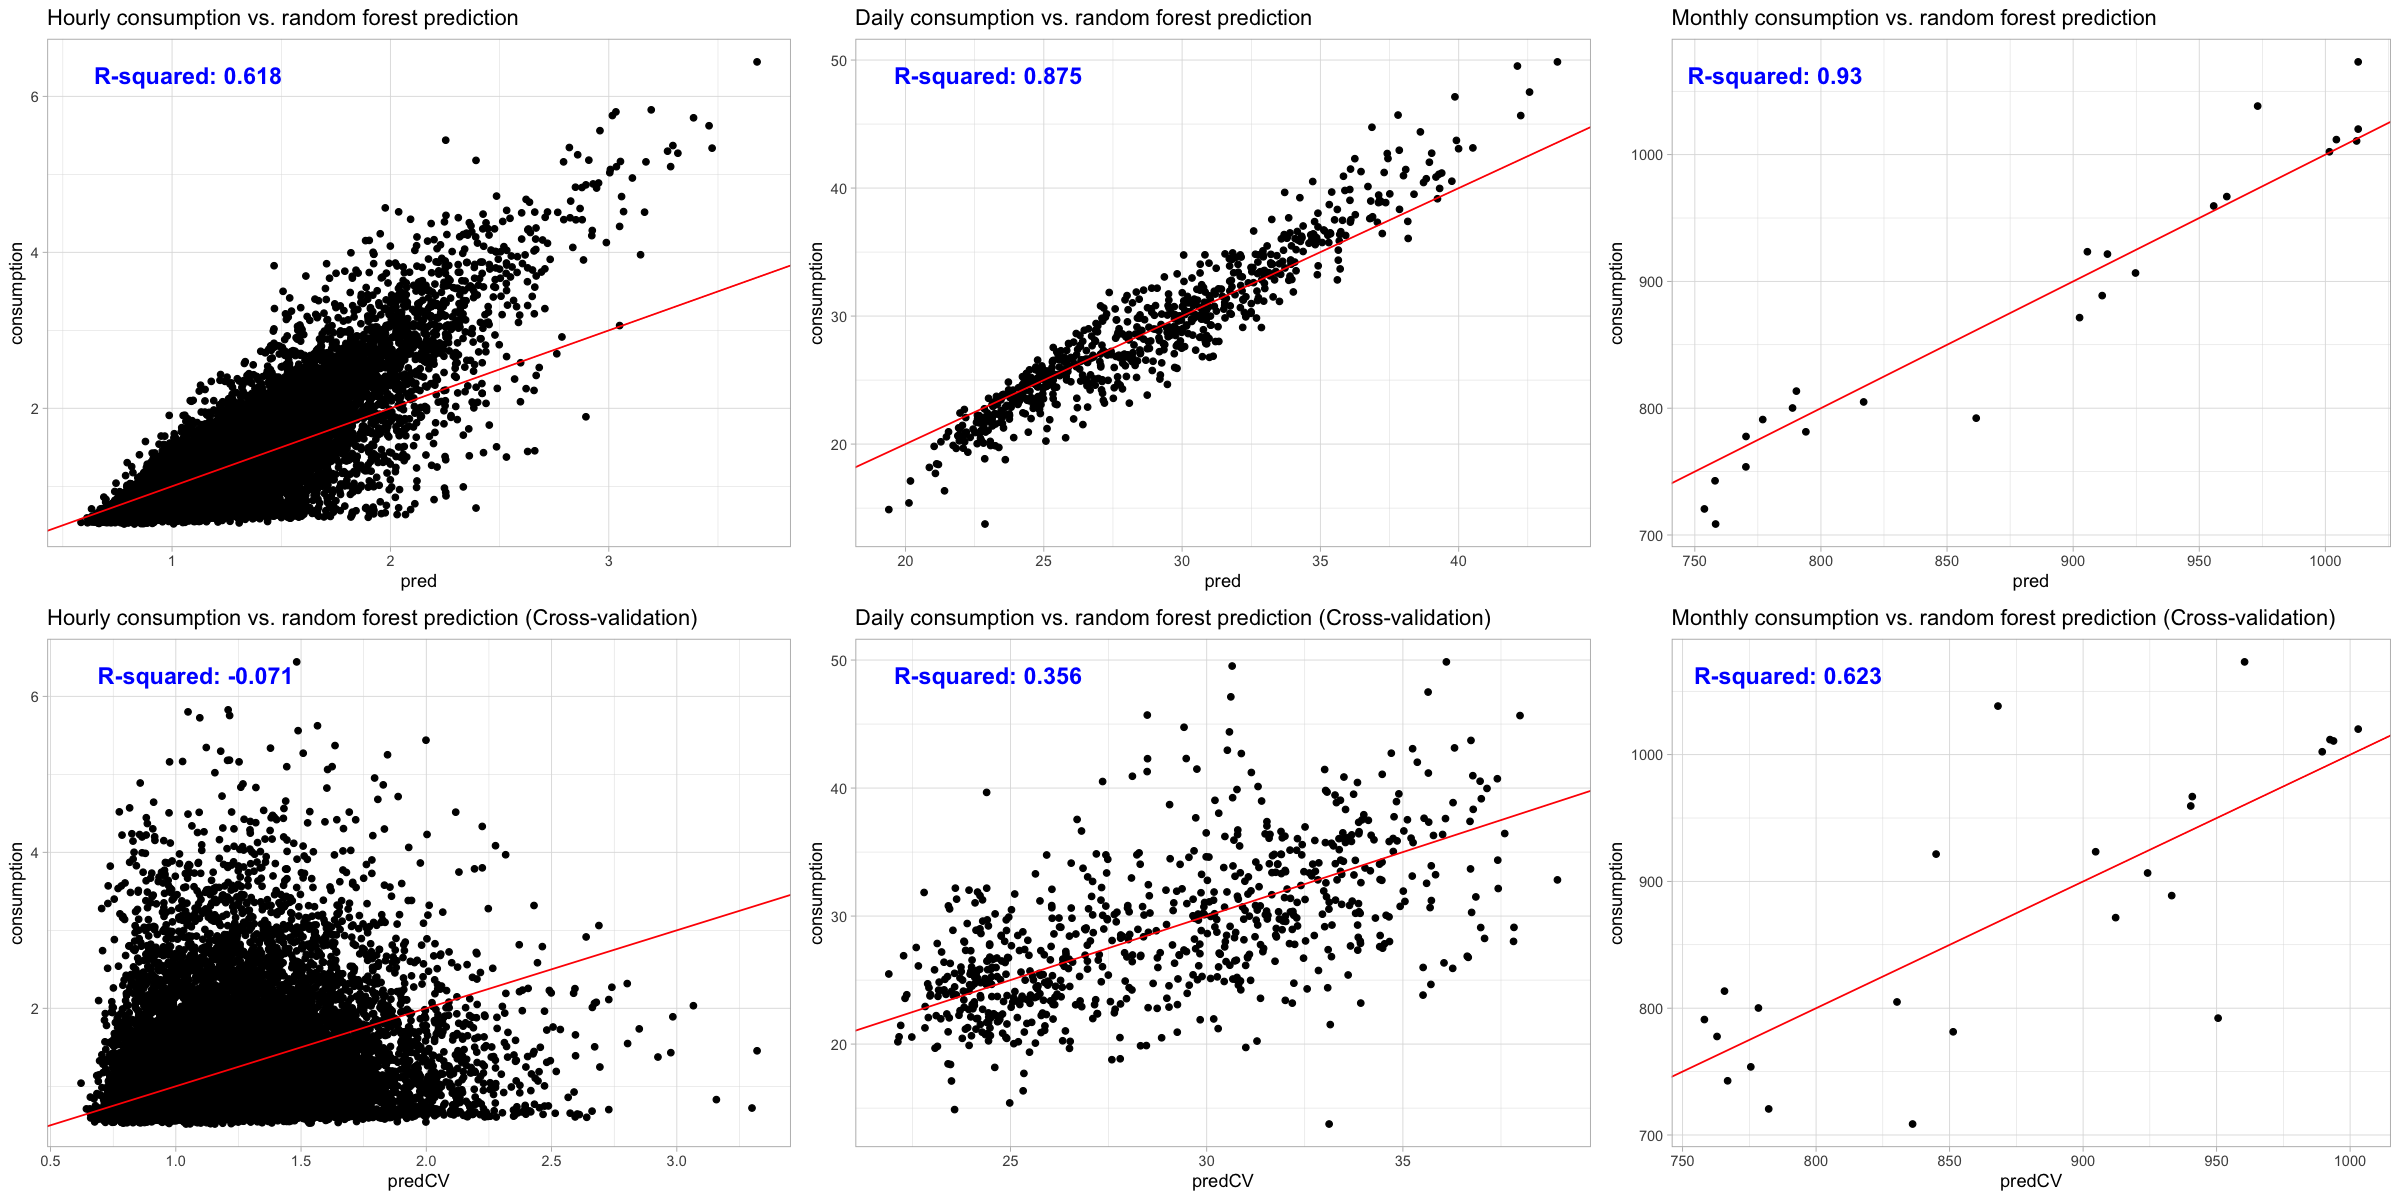

In [52]:
# Set configuration for plot size
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot definitions
plt_hour_pred       <- ggplot(WEHourDF,     aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. random forest prediction")                      + theme_light()
plt_day_pred        <- ggplot(WEDayDF,      aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. random forest prediction")                       + theme_light()
plt_month_pred      <- ggplot(WEMonthDF,    aes(x = pred,   y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction")                     + theme_light()
plt_hour_predCV     <- ggplot(WEHourDF,     aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Hourly consumption vs. random forest prediction (Cross-validation)")   + theme_light()
plt_day_predCV      <- ggplot(WEDayDF,      aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Daily consumption vs. random forest prediction (Cross-validation)")    + theme_light()
plt_month_predCV    <- ggplot(WEMonthDF,    aes(x = predCV, y = consumption)) + geom_point() + geom_abline(color = "red") + ggtitle("Monthly consumption vs. random forest prediction (Cross-validation)")  + theme_light()

# Grid of plots definition
plot_grid(
    plt_hour_pred, plt_day_pred, plt_month_pred, plt_hour_predCV, plt_day_predCV, plt_month_predCV,
    labels = c(
        paste0("R-squared: ", round(r_squared_func(WEHourDF,    "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEDayDF,     "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEMonthDF,   "consumption", "pred"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEHourDF,    "consumption", "predCV"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEDayDF,     "consumption", "predCV"), 3)), 
        paste0("R-squared: ", round(r_squared_func(WEMonthDF,   "consumption", "predCV"), 3))
    ), 
    hjust = -0.5, vjust = 5, label_colour = "blue",
    ncol = 3, nrow = 2
)